<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/UPerNet/Perform_inference_with_UperNetForSemanticSegmentation_(Swin_backbone).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: inference with UPerNet + Swin backbone for semantic segmentation

[UPerNet](https://arxiv.org/abs/1807.10221) is a classic computer vision framework introduced in 2018 for image segmentation. As it is a "framework" (which means, a complex system composed of several building blocks), it can be used with any vision backbone, like:

* [ConvNeXt](https://huggingface.co/docs/transformers/model_doc/convnext),
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin),
* [Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit),

etc.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/upernet_architecture.jpg" alt="drawing" width="600"/>

Several papers that introduce a new vision backbone benchmark it against this framework, to see whether the backbone really improves results on downstream tasks, like semantic segmentation. Performance for semantic segmentation is reported in terms of [mean Intersection-over-Union (mIoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou).

## Set-up environment

First, let's install 🤗 Transformers. We install from Github as UperNet is brand new at the time of writing, and not yet included in a new PyPi release.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load image

Let's load an image from the [ADE20k dataset](https://huggingface.co/datasets/scene_parse_150), an important benchmark for image segmentation.

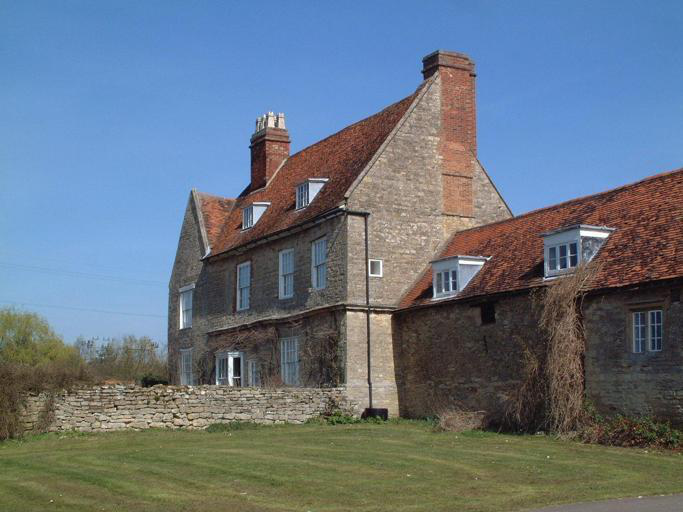

In [4]:
import requests
from PIL import Image

url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image 

## Load model

Next, we'll load a model from the [hub](https://huggingface.co/openmmlab/upernet-swin-base). In this case, we load an UperNet model with a Swin-base backbone.

In [16]:
from transformers import UperNetForSemanticSegmentation

model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-large")

Downloading:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/940M [00:00<?, ?B/s]

## Forward pass

Next, we prepare the image for the model, and forward the pixel values through the model.

In [17]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-large")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [18]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

The model outputs logits (which are unnormalized scores), per pixel. These are of shape (batch_size, number of labels, height, width). Hence the model outputs, for each pixel, a score for each class.

We'll simply take the highest score per pixel as prediction for that particular pixel.

In [24]:
print(outputs.logits.shape)

torch.Size([1, 150, 512, 512])


## Visualize predictions

To visualize, we first define a color palette, which maps each of the 150 ADE20k classes to a color (red, green and blue values).

In [19]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

For visualization, we overlay image with the predicted masks.

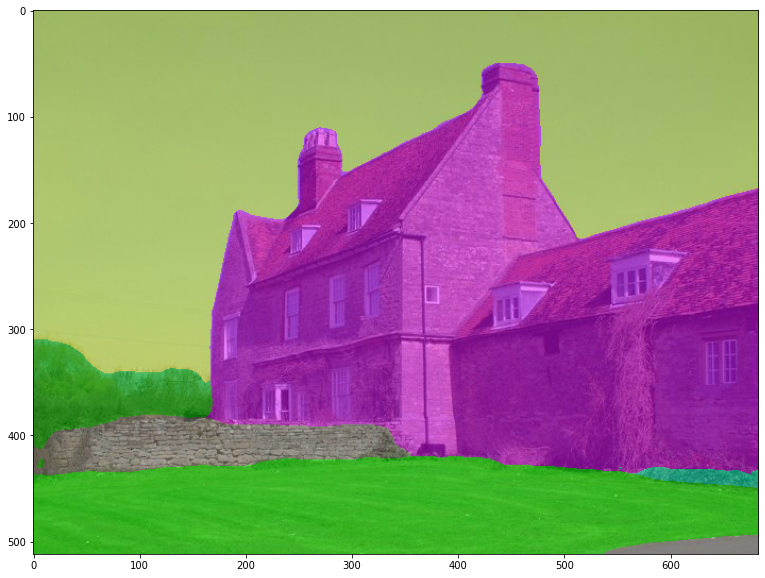

In [20]:
import matplotlib.pyplot as plt 
import numpy as np

seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()